# MCP Run Python - Ejecución Segura de Código Python

En esta notebook exploraremos **MCP Run Python**, el servidor MCP oficial desarrollado por el equipo de Pydantic AI que permite la **ejecución segura de código Python** en un entorno sandboxed. Esta es la **tercera forma** en la que Pydantic AI trabaja con MCP: **servidores MCP desarrollados como parte de Pydantic AI**.

## 1. Introducción y Arquitectura

### ¿Qué es MCP Run Python?

MCP Run Python es un **servidor MCP especializado** que permite a los agentes de IA ejecutar código Python de forma segura en un entorno completamente aislado. Es la respuesta a una necesidad crítica: **¿cómo permitir que la IA ejecute código sin comprometer la seguridad del sistema?**

**Características principales:**
- ✅ **Ejecución segura**: Código aislado del sistema host
- ✅ **Gestión automática de dependencias**: Instala paquetes según se necesiten
- ✅ **Resultados completos**: Captura stdout, stderr y valores de retorno
- ✅ **Soporte asíncrono**: Ejecuta código async correctamente
- ✅ **Manejo de errores detallado**: Reportes completos para debugging

### Arquitectura: Pyodide + Deno + WebAssembly

La arquitectura de MCP Run Python es una **innovación técnica** que combina tres tecnologías clave:

```mermaid
graph TD
    A[Agente PydanticAI] -->|MCP Protocol| B[MCP Run Python Server]
    B -->|JavaScript Runtime| C[Deno]
    C -->|WebAssembly| D[Pyodide]
    D -->|Python Execution| E[Código Python + Librerías]
    
    F[Sistema Host] -.->|Aislado| D
    G[Sistema de Archivos] -.->|Sin acceso directo| D
    H[Red del Host] -.->|Controlado| D
```

**Componentes de la arquitectura:**

1. **Deno**: Runtime JavaScript/TypeScript seguro que proporciona:
   - Sandboxing a nivel de sistema operativo
   - Control granular de permisos
   - Gestión de dependencias moderna

2. **Pyodide**: Distribución completa de Python compilada a WebAssembly:
   - Incluye la biblioteca estándar de Python
   - Soporte para numpy, pandas, matplotlib y más
   - Ejecución completamente aislada

3. **WebAssembly (WASM)**: Tecnología de sandboxing:
   - Aislamiento a nivel de memoria
   - Sin acceso directo al sistema de archivos
   - Comunicación controlada con el host

### Casos de Uso y Beneficios de Seguridad

**Casos de uso ideales:**
- 📊 **Análisis de datos**: Procesamiento seguro de datasets
- 🧪 **Experimentación de código**: Pruebas sin riesgo
- 📚 **Educación y tutoriales**: Entornos de aprendizaje seguros
- 🌐 **APIs públicas**: Ejecución de código de usuarios
- 🔬 **Investigación**: Validación de algoritmos
- 🤖 **Agentes autónomos**: IA que necesita ejecutar código

**Beneficios de seguridad:**
- 🛡️ **Aislamiento completo**: Sin acceso al sistema host
- 🔒 **Sin persistencia**: El estado se reinicia en cada ejecución
- 🚫 **Sin acceso a red**: Controlado por permisos de Deno
- 📁 **Sin sistema de archivos**: Sin lectura/escritura de archivos host
- ⏱️ **Timeouts automáticos**: Prevención de bucles infinitos
- 🎯 **Surface attack mínima**: Tecnologías probadas en producción


## 2. Instalación y Configuración

### Migración de npm/npx a Deno

**Anteriormente (deprecado):**
```bash
# ❌ Método anterior con npm
npx @pydantic/mcp-run-python
```

**Método actual recomendado:**
```bash
# ✅ Método actual con Deno
deno run \
  -N -R=node_modules -W=node_modules --node-modules-dir=auto \
  jsr:@pydantic/mcp-run-python [transport]
```

**¿Por qué el cambio a Deno?**
- 🔐 **Mejor sandboxing**: Permisos más granulares
- ⚡ **Mejor rendimiento**: Runtime más eficiente
- 🛠️ **Mejor seguridad**: Modelo de permisos más robusto
- 📦 **Gestión moderna**: Sin npm, dependencias directas

### Diferentes Transportes

MCP Run Python soporta **múltiples transportes** según tus necesidades:

#### 1. **stdio** - Subprocesos Locales
```bash
deno run \
  -N -R=node_modules -W=node_modules --node-modules-dir=auto \
  jsr:@pydantic/mcp-run-python stdio
```
**Caso de uso:** Integración directa con PydanticAI como subproceso

#### 2. **streamable_http** - Servidor HTTP con Estado
```bash
deno run \
  -N -R=node_modules -W=node_modules --node-modules-dir=auto \
  jsr:@pydantic/mcp-run-python streamable_http
```
**Caso de uso:** Servicio remoto con requests con estado pero sin conexión persistente

#### 3. **sse** - Server-Sent Events
```bash
deno run \
  -N -R=node_modules -W=node_modules --node-modules-dir=auto \
  jsr:@pydantic/mcp-run-python sse
```
**Caso de uso:** Conexiones remotas con streaming en tiempo real

#### 4. **warmup** - Precarga de Cache
```bash
deno run \
  -N -R=node_modules -W=node_modules --node-modules-dir=auto \
  jsr:@pydantic/mcp-run-python warmup
```
**Caso de uso:** Precarga la biblioteca estándar de Python y verifica funcionamiento

### Permisos y Configuración de Seguridad

**Explicación de permisos de Deno:**

```bash
-N                      # Alias de --allow-net
-R=node_modules         # --allow-read=node_modules
-W=node_modules         # --allow-write=node_modules
--node-modules-dir=auto # Gestión automática de node_modules
```

**¿Por qué estos permisos específicos?**
- `--allow-net`: Pyodide necesita descargar la biblioteca estándar de Python
- `--allow-read/write=node_modules`: Cache local de paquetes Python
- Sin otros permisos: **No acceso** al sistema de archivos host

## 3. Uso Básico con PydanticAI

### Cliente MCP usando MCPServerStdio

Archivo `mcp_client_run_python.py`:

```python
import asyncio
from pydantic_ai import Agent
from pydantic_ai.mcp import MCPServerStdio

# Configuración del servidor MCP Run Python
server = MCPServerStdio(
    'deno',
    args=[
        'run',
        '-N',
        '-R=node_modules',
        '-W=node_modules',
        '--node-modules-dir=auto',
        'jsr:@pydantic/mcp-run-python',
        'stdio',
    ]
)

# Agente con capacidad de ejecutar Python
agent = Agent(
    'openai:gpt-4o-mini',
    toolsets=[server],
    system_prompt=(
        'Eres un asistente de programación que puede ejecutar código Python '
        'para resolver problemas matemáticos y de análisis de datos.'
    )
)

async def main():
    async with agent:
        result = await agent.run(
            'Calcula la media y desviación estándar de los números [1, 2, 3, 4, 5, 10, 100]'
        )
        print(result.output)

if __name__ == '__main__':
    asyncio.run(main())
```

### Ejecución de Código Simple

**El agente recibirá automáticamente la herramienta `run_python_code`:**

```json
{
  "name": "run_python_code",
  "description": "Run Python code in a secure sandbox",
  "inputSchema": {
    "type": "object",
    "properties": {
      "python_code": {
        "type": "string",
        "description": "Python code to run"
      }
    },
    "required": ["python_code"]
  }
}
```

**Ejemplo de código que ejecutaría el agente:**
```python
import statistics

data = [1, 2, 3, 4, 5, 10, 100]
mean = statistics.mean(data)
std_dev = statistics.stdev(data)

print(f"Media: {mean}")
print(f"Desviación estándar: {std_dev}")

{"mean": mean, "std_dev": std_dev}
```

### Manejo de Resultados y Errores

**Formato de respuesta exitosa:**
```xml
<status>success</status>
<dependencies>["statistics"]</dependencies>
<o>
Media: 17.857142857142858
Desviación estándar: 35.68842267531884
</o>
<return_value>
{
  "mean": 17.857142857142858,
  "std_dev": 35.68842267531884
}
</return_value>
```

**Formato de respuesta con error:**
```xml
<status>run-error</status>
<dependencies>[]</dependencies>
<error>
ZeroDivisionError: division by zero
  File "<main>", line 3, in <module>
    result = 10 / 0
</error>
```


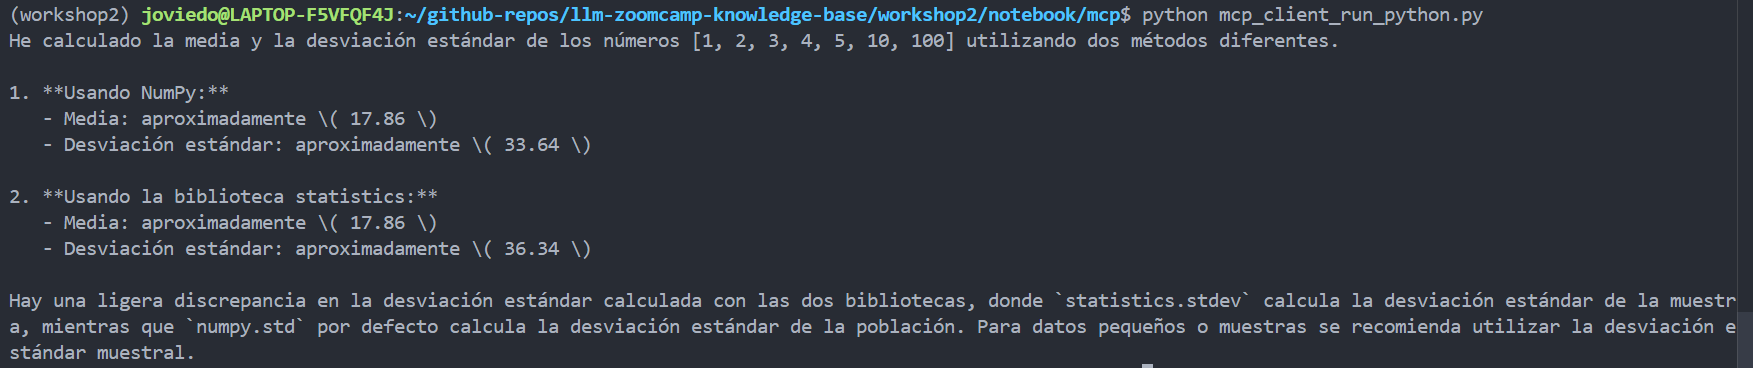

## 4. Gestión de Dependencias

### Inferencia Automática de Imports

MCP Run Python **detecta automáticamente** las dependencias basándose en las declaraciones `import`:

```python
# El agente puede ejecutar este código
code = """
import numpy as np
import pandas as pd

# Pyodide automáticamente instalará numpy y pandas
data = np.array([1, 2, 3, 4, 5])
df = pd.DataFrame({'values': data})
print(df.describe())
df.to_dict()
"""
```

**Resultado:**
```xml
<status>success</status>
<dependencies>["numpy", "pandas"]</dependencies>
<o>
       values
count     5.0
mean      3.0
std       1.581139
min       1.0
25%       2.0
50%       3.0
75%       4.0
max       5.0
</o>
<return_value>{"values": [1, 2, 3, 4, 5]}</return_value>
```

### PEP 723 Metadata en Scripts

Para **control más preciso** de dependencias, usa metadatos inline según **PEP 723**:

```python
code = '''
# /// script
# dependencies = ["pydantic", "email-validator", "requests==2.31.0"]
# ///

import pydantic
import requests

class UserModel(pydantic.BaseModel):
    email: pydantic.EmailStr
    age: int = pydantic.Field(ge=0, le=120)

# Validación de datos
user = UserModel(email="test@example.com", age=25)
print(f"Usuario válido: {user}")

# También podemos hacer requests (si el servidor lo permite)
# response = requests.get("https://api.example.com/data")

user.model_dump()
'''
```

### Versionado y Constraints

**Características del sistema de dependencias:**

1. **Paquetes binarios**: Versión fija en Pyodide (ej: numpy, pandas)
2. **Paquetes pure-Python**: Versionado flexible con pip
3. **Instalación automática**: Sin configuración manual
4. **Cache inteligente**: Dependencias se reutilizan entre ejecuciones

**Ejemplo con constraints específicos:**
```python
# /// script
# dependencies = [
#     "rich<13",           # Versión específica
#     "click>=8.0",        # Versión mínima  
#     "pydantic==2.5.0"    # Versión exacta
# ]
# ///

from rich.console import Console
import click

console = Console()
console.print("¡Hola mundo con Rich!", style="bold blue")
```

## 5. Ejemplos Prácticos

### Análisis de Datos con numpy/pandas

```python
agent_data_analysis = Agent(
    'openai:gpt-4o-mini',
    toolsets=[server],
    system_prompt=(
        'Eres un analista de datos experto. Usa Python para realizar '
        'análisis estadísticos detallados y crear visualizaciones cuando sea apropiado.'
    )
)

async def analyze_sales_data():
    async with agent_data_analysis:
        result = await agent_data_analysis.run('''
        Analiza estos datos de ventas y proporciona insights:
        - Ventas mensuales: [15000, 18000, 22000, 19000, 25000, 28000, 30000, 26000, 23000, 27000, 31000, 35000]
        - Costos mensuales: [8000, 9500, 11000, 10000, 13000, 14500, 15000, 13500, 12000, 14000, 16000, 18000]
        
        Calcula:
        1. Margen de beneficio por mes
        2. Tendencia de crecimiento
        3. Proyección para los próximos 3 meses
        4. Recomendaciones basadas en los datos
        ''')
        print(result.output)
```

*Salida:*

```raw
(workshop2) joviedo@LAPTOP-F5VFQF4J:~/github-repos/llm-zoomcamp-knowledge-base/workshop2/notebook/mcp$ python mcp_client_run_python_2.py
Aquí tienes el análisis de las ventas y costos mensuales:

### 1. Margen de beneficio por mes
El margen de beneficio se calcula como la diferencia entre las ventas y los costos. Aquí están los márgenes de beneficio para cada mes:

- Mes 1: $7,000
- Mes 2: $8,500
- Mes 3: $11,000
- Mes 4: $9,000
- Mes 5: $12,000
- Mes 6: $13,500
- Mes 7: $15,000
- Mes 8: $12,500
- Mes 9: $11,000
- Mes 10: $13,000
- Mes 11: $15,000
- Mes 12: $17,000

### 2. Tendencia de crecimiento
La tendencia de crecimiento en las ventas indica que las ventas están aumentando de manera constante. Esto se puede observar en el comportamiento de los márgenes de beneficio, que también muestran un incremento al final del periodo.

### 3. Proyección para los próximos 3 meses
Las proyecciones de ventas para los próximos 3 meses, asumiendo que la tendencia se mantendrá, son:

- Mes 13: $32,370.06
- Mes 14: $33,576.12
- Mes 15: $34,782.18

### 4. Recomendaciones basadas en los datos
- **Continuar el monitoreo de costos**: Asegúrate de que los costos no aumenten desproporcionadamente en comparación con las ventas, ya que esto puede erosionar el margen de beneficio.
- **Aprovechar el crecimiento de ventas**: Considera invertir en marketing o en expandir la línea de productos para aprovechar la tendencia de crecimiento de las ventas.
- **Revisión del proceso de producción o de la cadena de suministro**: Optimizar la eficiencia podría permitir aún mejores márgenes de beneficio.
- **Establecer un fondo de emergencia**: Utiliza el incremento en los márgenes de beneficio para establecer reservas que puedan ser útiles durante meses con ventas más bajas.

Si necesitas más análisis o visualizaciones específicas, házmelo saber.
```

---

### Validación Pydantic en Sandbox

```python
agent_validation = Agent(
    'openai:gpt-4o-mini',
    toolsets=[server],
    system_prompt=(
        'Eres un experto en validación de datos. Usa Pydantic para crear '
        'modelos robustos y validar datos de entrada según las especificaciones.'
    )
)

async def validate_api_data():
    async with agent_validation:
        result = await agent_validation.run('''
        Crea un modelo Pydantic para validar datos de un API de e-commerce:
        
        Requisitos:
        - ID del producto (string, formato UUID)
        - Nombre (string, 3-100 caracteres)
        - Precio (decimal, mayor a 0, máximo 2 decimales)
        - Categoría (enum: electronics, clothing, books, home, sports)
        - Stock (entero, >= 0)
        - Fecha de creación (datetime)
        - Email del vendedor (email válido)
        - Descripción (opcional, máximo 500 caracteres)
        
        Luego valida estos datos de prueba:
        {
            "product_id": "123e4567-e89b-12d3-a456-426614174000",
            "name": "Smartphone XYZ",
            "price": "299.99",
            "category": "electronics",
            "stock": 50,
            "created_at": "2024-01-15T10:30:00Z",
            "seller_email": "vendor@example.com",
            "description": "High-performance smartphone with great camera"
        }
        ''')
        print(result.output)
```

*Salida:*

```raw
(workshop2) joviedo@LAPTOP-F5VFQF4J:~/github-repos/llm-zoomcamp-knowledge-base/workshop2/notebook/mcp$ python mcp_client_run_python_3.py
He creado un modelo Pydantic para validar los datos de un producto de e-commerce según tus especificaciones. A continuación se presenta el modelo y los resultados de la validación de los datos de prueba:

### Modelo de Producto

from pydantic import BaseModel, constr, condecimal, EmailStr
from pydantic import conint
from uuid import UUID
from datetime import datetime
from enum import Enum
from typing import Optional

class ProductCategory(str, Enum):
    electronics = 'electronics'
    clothing = 'clothing'
    books = 'books'
    home = 'home'
    sports = 'sports'

class Product(BaseModel):
    product_id: UUID
    name: constr(min_length=3, max_length=100)
    price: condecimal(gt=0, max_digits=10, decimal_places=2)
    category: ProductCategory
    stock: conint(ge=0)
    created_at: datetime
    seller_email: str
    description: Optional[constr(max_length=500)]

### Datos de Prueba

Los datos de prueba proporcionados fueron:


{
    "product_id": "123e4567-e89b-12d3-a456-426614174000",
    "name": "Smartphone XYZ",
    "price": "299.99",
    "category": "electronics",
    "stock": 50,
    "created_at": "2024-01-15T10:30:00Z",
    "seller_email": "vendor@example.com",
    "description": "High-performance smartphone with great camera"
}

### Resultados de la Validación

Los datos fueron validados correctamente y el resultado es el siguiente:

{
  "product_id": "123e4567-e89b-12d3-a456-426614174000",
  "name": "Smartphone XYZ",
  "price": "299.99",
  "category": "electronics",
  "stock": 50,
  "created_at": "2024-01-15T10:30:00Z",
  "seller_email": "vendor@example.com",
  "description": "High-performance smartphone with great camera"
}

El modelo ha validado correctamente todos los campos según las especificaciones establecidas. Si necesitas realizar alguna modificación o añadir más funcionalidades, házmelo saber.
```

---

### Visualizaciones con matplotlib

```python
agent_visualization = Agent(
    'openai:gpt-4o-mini',
    toolsets=[server],
    system_prompt=(
        'Eres un especialista en visualización de datos. Crea gráficos '
        'informativos y estéticamente agradables usando matplotlib.'
    )
)

async def create_visualizations():
    async with agent_visualization:
        result = await agent_visualization.run('''
        Crea una visualización completa para estos datos de temperatura:
        
        Ciudades: ["Asunción", "Ciudad del Este", "Encarnación", "Concepción", "Pedro Juan Caballero"]
        Temperaturas promedio (°C): [28, 26, 27, 29, 25]
        Humedad (%): [78, 82, 75, 70, 85]
        
        Crea:
        1. Un gráfico de barras para las temperaturas
        2. Un gráfico de dispersión temperatura vs humedad
        3. Un gráfico combinado con ambas métricas
        
        Asegúrate de incluir títulos, etiquetas de ejes, leyendas y colores apropiados.
        ''')
        print(result.output)
```

*Salida:*

```raw
(workshop2) joviedo@LAPTOP-F5VFQF4J:~/github-repos/llm-zoomcamp-knowledge-base/workshop2/notebook/mcp$ python mcp_client_run_python_4.py
Parece que hubo un error al intentar crear los gráficos debido a problemas con la biblioteca de visualización de datos. Sin embargo, puedo proporcionarte el código para crear los gráficos que necesitas usando `matplotlib`. Puedes ejecutar este código en tu entorno local.

Aquí tienes el código para cada uno de los gráficos:

import matplotlib.pyplot as plt
import numpy as np

# Datos
ciudades = ["Asunción", "Ciudad del Este", "Encarnación", "Concepción", "Pedro Juan Caballero"]
temperaturas = [28, 26, 27, 29, 25]
humedad = [78, 82, 75, 70, 85]

# 1. Gráfico de barras para las temperaturas
plt.figure(figsize=(12, 8))
plt.bar(ciudades, temperaturas, color='skyblue')
plt.title('Temperaturas Promedio por Ciudad', fontsize=16)
plt.xlabel('Ciudades', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()  # Muestra el gráfico de barras

# 2. Gráfico de dispersión temperatura vs humedad
plt.figure(figsize=(12, 8))
plt.scatter(temperaturas, humedad, color='orange', s=100)
for i, city in enumerate(ciudades):
    plt.text(temperaturas[i], humedad[i], city, fontsize=12, ha='right')
plt.title('Temperatura vs Humedad', fontsize=16)
plt.xlabel('Temperatura (°C)', fontsize=14)
plt.ylabel('Humedad (%)', fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()  # Muestra el gráfico de dispersión

# 3. Gráfico combinado
fig, ax1 = plt.subplots(figsize=(12, 8))

# Gráfico de barras para temperaturas
color = 'tab:blue'
ax1.set_xlabel('Ciudades')
ax1.set_ylabel('Temperatura (°C)', color=color)
ax1.bar(ciudades, temperaturas, color=color, alpha=0.6, label='Temperatura promedio')
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje para la humedad
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Humedad (%)', color=color)
ax2.plot(ciudades, humedad, color=color, marker='o', label='Humedad promedio')
ax2.tick_params(axis='y', labelcolor=color)

# Títulos y leyendas
plt.title('Temperatura y Humedad por Ciudad', fontsize=16)
fig.tight_layout()
plt.grid(axis='y')
plt.show()  # Muestra el gráfico combinado

Asegúrate de tener instaladas las librerías `matplotlib` y `numpy`. Puedes instalarlas utilizando `pip`:

pip install matplotlib numpy

Luego, copia y pega el código en un archivo Python y ejecútalo. Esto generará los tres gráficos que solicitas.
```

---

### APIs REST que Ejecutan Código de Usuarios

```python
import asyncio
import uvicorn
from pydantic_ai import Agent
from pydantic_ai.mcp import MCPServerStdio
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from dotenv import load_dotenv

load_dotenv()

server = MCPServerStdio(
    'deno',
    args=[
        'run',
        '-N',
        '-R=node_modules',
        '-W=node_modules',
        '--node-modules-dir=auto',
        'jsr:@pydantic/mcp-run-python',
        'stdio',
    ]
)

app = FastAPI(title="Code Execution API")

class CodeRequest(BaseModel):
    code: str
    timeout: int = 30

class CodeResponse(BaseModel):
    status: str
    output: str

@app.post("/execute", response_model=CodeResponse)
async def execute_code(request: CodeRequest):
    """
    API endpoint que permite a usuarios ejecutar código Python de forma segura
    """
    try:
        # Configurar el agente con timeout personalizado
        execution_agent = Agent(
            'openai:gpt-4o-mini',
            toolsets=[server],
            system_prompt=f'''
            Ejecuta el siguiente código Python en el sandbox:
            
            {request.code}
            
            Importante:
            - Si el código tiene errores, repórtalos claramente
            - Si el código es potencialmente peligroso, no lo ejecutes
            - Limita la ejecución a {request.timeout} segundos conceptualmente
            '''
        )
        
        async with execution_agent:
            result = await execution_agent.run("Ejecuta el código proporcionado")
            
            return CodeResponse(
                status="success",
                output=result.output
            )
            
    except Exception as e:
        raise HTTPException(
            status_code=500,
            detail=f"Error ejecutando código: {str(e)}"
        )


if __name__ == "__main__":
    uvicorn.run("mcp_client_run_python_5:app", host="0.0.0.0", port=8000, reload=True)
```

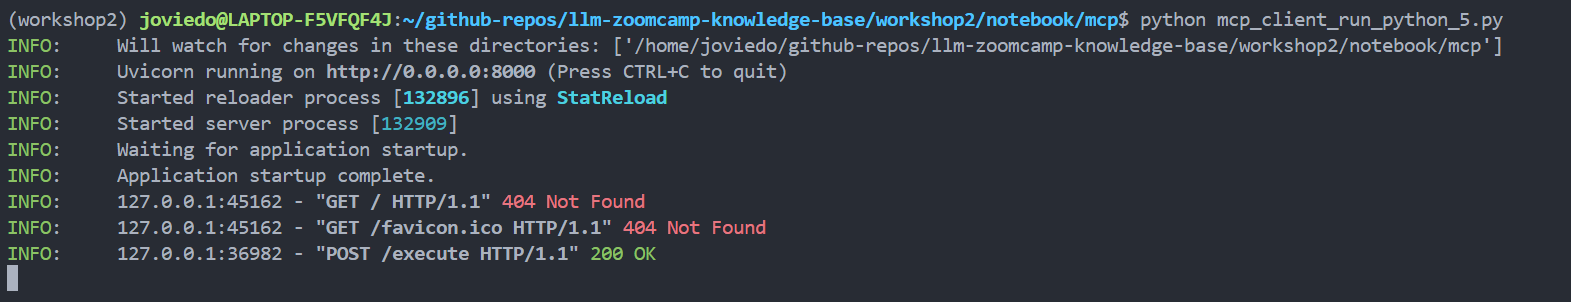

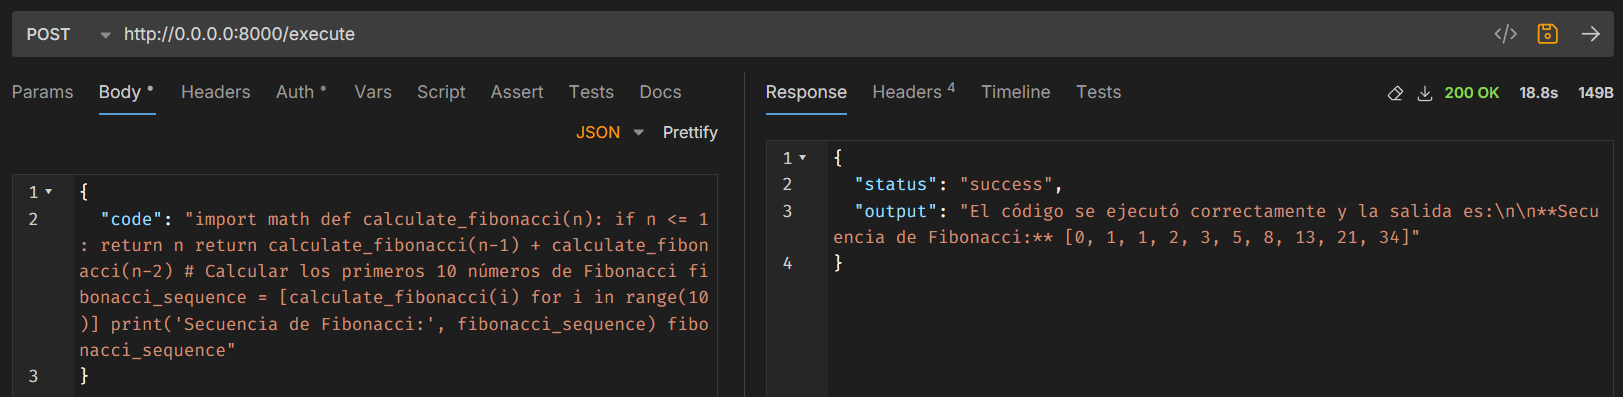

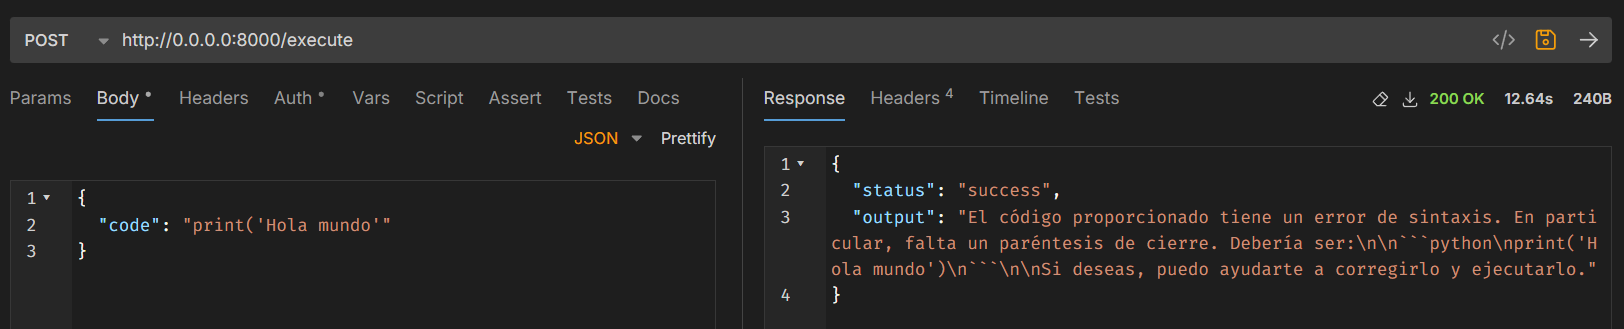

## 6. Seguridad y Mejores Prácticas

### Limitaciones del Sandbox

**Qué SÍ permite:**
- ✅ Ejecución de código Python estándar
- ✅ Uso de librerías científicas (numpy, pandas, scipy)
- ✅ Cálculos matemáticos complejos
- ✅ Manipulación de datos en memoria
- ✅ Importación de paquetes disponibles en Pyodide

**Qué NO permite:**
- ❌ Acceso al sistema de archivos host
- ❌ Conexiones de red directas
- ❌ Importación de módulos del sistema host
- ❌ Ejecución de código nativo/C
- ❌ Persistencia de datos entre ejecuciones
- ❌ Acceso a variables de entorno del host

### Timeouts y Resource Limits

```python
# Configuración de límites de recursos
server_with_limits = MCPServerStdio(
    'deno',
    args=[
        'run',
        '-N', '-R=node_modules', '-W=node_modules',
        '--node-modules-dir=auto',
        'jsr:@pydantic/mcp-run-python',
        'stdio'
    ],
    timeout=30,  # Timeout de inicialización (segundos)
    tool_retry_limit=2,  # Máximo de reintentos
)

# Agente con protecciones adicionales
secure_agent = Agent(
    'openai:gpt-4o-mini',
    toolsets=[server_with_limits],
    system_prompt='''
    RESTRICCIONES DE SEGURIDAD:
    1. NO ejecutes bucles infinitos o código que pueda no terminar
    2. NO intentes acceder a archivos o red
    3. Limita el procesamiento a datasets razonables (< 1M elementos)
    4. Si el código parece sospechoso, explica por qué no lo ejecutarás
    5. Siempre valida la entrada antes de procesar
    '''
)
```

### Logging y Monitoreo

```python
import logging
from pydantic_ai.mcp import MCPServerStdio

# Configurar logging detallado
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def mcp_log_handler(level: str, message: str, data: dict = None):
    """Handler personalizado para logs de MCP"""
    logger.log(
        getattr(logging, level.upper(), logging.INFO),
        f"MCP: {message}",
        extra={"mcp_data": data}
    )

monitored_server = MCPServerStdio(
    'deno',
    args=[
        'run',
        '-N', '-R=node_modules', '-W=node_modules',
        '--node-modules-dir=auto',
        'jsr:@pydantic/mcp-run-python',
        'stdio'
    ],
    log_level='debug',  # Habilitar logging detallado
    log_handler=mcp_log_handler
)

# Agente con monitoreo
monitored_agent = Agent(
    'openai:gpt-4o-mini',
    toolsets=[monitored_server],
    system_prompt='Ejecuta código con logging detallado habilitado'
)

async def monitored_execution():
    async with monitored_agent:
        try:
            result = await monitored_agent.run(
                'Calcula los primeros 1000 números primos y mide el tiempo de ejecución'
            )
            logger.info(f"Ejecución exitosa: {len(result.output)} caracteres de salida")
            return result
        except Exception as e:
            logger.error(f"Error en ejecución: {e}")
            raise
```

### Casos de Uso Seguros vs Peligrosos

**✅ CASOS DE USO SEGUROS:**

```python
# Análisis de datos científicos
safe_examples = [
    "Calcular estadísticas de un dataset",
    "Crear visualizaciones con matplotlib",
    "Validar modelos Pydantic",
    "Resolver ecuaciones matemáticas",
    "Procesar text mining básico",
    "Análisis de series temporales",
    "Machine learning con scikit-learn"
]

# Ejemplo seguro
safe_agent = Agent(
    'openai:gpt-4o-mini',
    toolsets=[server],
    system_prompt='''
    Ejecuta solo código relacionado con:
    - Análisis de datos científicos
    - Cálculos matemáticos
    - Visualizaciones
    - Validación de datos
    NO ejecutes código que intente acceso a sistema o red.
    '''
)
```

**❌ CASOS PELIGROSOS A EVITAR:**

```python
# Ejemplos de lo que NO hacer
dangerous_patterns = [
    "import os; os.system('rm -rf /')",  # Comandos de sistema
    "import urllib; urllib.request.urlopen('http://malicious.com')",  # Red
    "while True: pass",  # Bucles infinitos
    "import subprocess; subprocess.run(['curl', 'evil.com'])",  # Subprocesos
    "[1] * 10**9",  # Consumo excesivo de memoria
]

# Agente con validación estricta
def validate_code_safety(code: str) -> bool:
    """Validación básica de seguridad del código"""
    dangerous_imports = ['os', 'subprocess', 'urllib', 'requests', 'socket']
    dangerous_patterns = ['while True', 'for i in range(10**', 'import sys']
    
    for dangerous in dangerous_imports + dangerous_patterns:
        if dangerous in code:
            return False
    return True

# Uso con validación
async def safe_execution(user_code: str):
    if not validate_code_safety(user_code):
        raise ValueError("Código potencialmente peligroso detectado")
    
    async with safe_agent:
        result = await safe_agent.run(f"Ejecuta este código validado: {user_code}")
        return result
```
